# ML Engineering Tutorial: Facial Expression Recognition
*Tutor: Ralf Mayet (mayet@campus.tu-berlin.de)<br>Adaptive Systems Group, Humboldt University Berlin*

**Scope:** Train a machine learning model to classify facial expressions based on a labelled dataset according to Ekman's "six basic emotions" [1].

**Important:** Facial Expression Recognition models trained on the "six basic emotion" categories are often also called "emotion detection". However, emotions are complex and exact classification and recognition of them remain challenging areas of research. We will be discussing some of these aspects during the development and in the final evaluation of our model.

## References

  - [1] https://en.wikipedia.org/wiki/Emotion#Basic_emotions
  - [2] http://deeplearning.net/icml2013-workshop-competition
  - [3] https://github.com/nhduong/fer2013 (Model implementation based on this)
  - [4] https://github.com/shantnu/Webcam-Face-Detect (Webcam demo implementation based on this)
  - [5] https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

# Data

To train our machine learning classifier we first need to find a suitable dataset for training. We established that we need images of faces that are labelled using Ekman's emotion categories: anger, surprise, disgust, sadness, happiness, surprise (and neutral). To find datasets we can use Google, [Google's Datasetsearch](https://datasetsearch.research.google.com) or other resources like [Papers With Code](https://paperswithcode.com). Important things to look out for when researching datasets is licensing conditions, amount of data and quality of annotations.

In this tutorial we will be using the [FER2013 Dataset from a Kaggle Machine Learning Competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) (see also reference [2]). After downloading the dataset we extract the file called `fer2013.csv` and make it accessible to this script/notebook.

In [2]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Loading the dataset
datapath = '/content/drive/MyDrive/FER/fer2013.csv'
dataset = np.genfromtxt(datapath, delimiter=',', skip_header=1, dtype=str)

In [4]:
# Examining the dataset
print("Dataset Shape: " + str(dataset.shape)) # Output: (35887, 3)

# From inspecting the data we know that the content of each row is: 
#   0: emotion ID
#   1: pixels (space seperated)
#   2: usage ("Training/Test/Validation")

Dataset Shape: (35887, 3)


In [38]:
# Print emotion categories of the first 10 samples:
print("Emotion IDs: " + str(dataset[:10,0]))
# From [5] we can see that 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral:
emotion_ids = ["anger", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
print("Emotion Categories: " + str([emotion_ids[int(e)] for e in dataset[:10,0]]))

Emotion IDs: ['0' '0' '2' '4' '6' '2' '4' '3' '3' '2']
Emotion Categories: ['anger', 'anger', 'fear', 'sad', 'neutral', 'fear', 'sad', 'happy', 'happy', 'fear']


(array([4953., 5121., 6077., 6198., 8989., 4002.]),
 array([-0.4,  0.6,  1.6,  2.6,  3.6,  4.6,  5.6]),
 <a list of 6 Patch objects>)

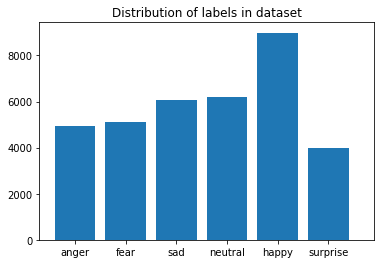

In [54]:
# Histogram of emotion categories in data
emotions = [emotion_ids[int(e)] for e in dataset[:,0]]
plt.title("Distribution of labels in dataset")
plt.hist(emotions, bins=np.arange(7)-0.4, width=0.8)

In [6]:
# Print usage types of the first 10 samples:
print("Usage Types: " + str(dataset[:10,2]))

Usage Types: ['Training' 'Training' 'Training' 'Training' 'Training' 'Training'
 'Training' 'Training' 'Training' 'Training']


visualizing picture id 33888
[[22 41 26 ... 14 18 26]
 [21 38 25 ... 14 15 27]
 [19 28 13 ... 14 20 43]
 ...
 [44 48 19 ... 49 48 49]
 [41 53 28 ... 42 40 37]
 [39 50 33 ... 31 31 30]]
Emotion Label: happy


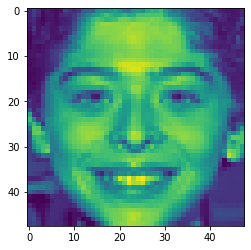

In [7]:
# Visualize random image
random_id = np.random.randint(0,dataset.shape[0])
print("visualizing picture id %d" % random_id)

image_pixel_string = dataset[random_id,1]
image_pixel_string_list = image_pixel_string.split(" ")
image_pixel_int_list = [int(pixel) for pixel in image_pixel_string_list]

image = np.array(image_pixel_int_list)
image = image.reshape((48,48))

print(image)
plt.imshow(image)

print("Emotion Label: %s" % emotion_ids[int(dataset[random_id, 0])])


In [8]:
# Generate One-Hot Encoding labels from raw data
emotion_ids = [int(emotion_category) for emotion_category in dataset[:,0]]
n_values = np.max(emotion_ids) + 1

# See https://www.pythonprogramming.in/numpy-eye-array-example.html
y = np.eye(n_values)[emotion_ids]

print("One hot encoding labels in y:")
print(y)

One hot encoding labels in y:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [9]:
# Generate Large Matrix for pixel values
picture_data = [img_string.split(" ") for img_string in dataset[:,1]]
picture_data = np.array(picture_data, dtype=int)
X = picture_data.reshape(picture_data.shape[0], 48, 48, 1)

[1. 0. 0. 0. 0. 0. 0.]


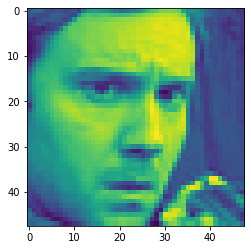

In [12]:
# plot single image
plt.imshow(X[0,:,:,0])
print(y[0])

In [13]:
# Make sure we are on the right track
assert(X.shape[0] == y.shape[0])

In [14]:
# Split data for consumption by model
training_examples = int(X.shape[0] * 0.8) # 80% split

x_training = X[:training_examples]
y_training = y[:training_examples]

x_testing = X[training_examples:]
y_testing = y[training_examples:]

# We could make a validation dataset here...

print("number of training examples: %i" % x_training.shape[0])
print("number of testing examples: %i" % x_testing.shape[0])


number of training examples: 28709
number of testing examples: 7178


# Model

In [16]:
# Importing packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

In [17]:
# Create our model
n_classes = 7
img_dim = 48

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [76]:
# Set Training parameters and train model
batch_size = 128
n_epoches = 500
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Takes around X epochs (43s/epoch on Colab GPU == )
history = model.fit(x_training, y_training, batch_size=batch_size, epochs=n_epoches,
          validation_data=(x_testing, y_testing), shuffle=True,
          callbacks=[early_stopping])


225/225 [==============================] - 44s 195ms/step - loss: 0.7367 - accuracy: 0.9590 - val_loss: 2.3409 - val_accuracy: 0.6038


{'loss': [0.73673415184021], 'accuracy': [0.9590372443199158], 'val_loss': [2.3409438133239746], 'val_accuracy': [0.6037893295288086]}


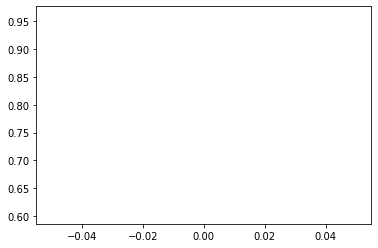

In [83]:
# Plot the training loss and model accuracy
print(history.history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [55]:
# Save model parameters to file
model.save('fer2013.h5')
model.save_weights('fer2013_weights.h5')

# Evaluation: Offline

In [56]:
# Accuracy on testing dataset
scores = model.evaluate(x_testing, y_testing)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

225/225 [==============================] - 5s 19ms/step - loss: 2.4064 - accuracy: 0.6052
accuracy: 60.52%


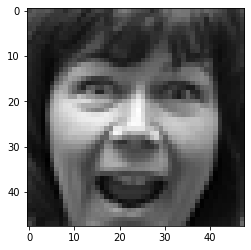

> testing image index: 3936
> true emotion: surprise
> predicted emotion: surprise


In [75]:
# Test individual image
random_id = np.random.randint(0,x_testing.shape[0])
sample = x_testing[random_id, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()

ground_truth_emotion = emotion_ids[np.argmax(y_testing[random_id, :])]
predicted_emotion = emotion_ids[np.argmax(pred_cls)]

print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (random_id, ground_truth_emotion, predicted_emotion))

# Evaluation: Online using Webcam

We can evaluate the performance of our classification algorithm in a real-time setting using a webcam. This way we can tell if it will be useful for example to use it in a human-robot interaction study setting using a robot camera to sense and respond to the facial expression of a user.

- See Demo on Desktop